# Start kit for Task 2 - Motor Imagery decoding transfer learning challenge

We recommand you to read the 'LeaderboardDataGuide' and visit the https://beetl.ai to get familar with data and tasks before you read this start kit.

## Objective of the tutorial

In this start kit, we will show how to use MOABB to load BNCI2014001,Cho2017,PhysionetMI motor imagery data sets for the cross-data set and cross-subject challenge. We also show an example pipeline of the challenge including:

- Environment Setup
- Source Motor imagery Data sets loading
- Source and target domain data organisation
- Training and evaluation procedure using an example shallow CNN.

References:

> MOABB website http://moabb.neurotechx.com/docs/index.html

> Schirrmeister, Robin Tibor, et al. "Deep learning with convolutional neural networks for EEG decoding and visualization." Human brain mapping 38.11 (2017): 5391-5420.

> Braindecode https://braindecode.org 

> dl-eeg-tutorial https://github.com/hubertjb/dl-eeg-tutorial



## Environment Setup

In [1]:
# !pip install torch
# !pip install mne
# !pip install matplotlib
# !pip install scikit-learn
# !pip install pandas
# !pip install braindecode
# !pip install moabb

Import packages and set ramdom SEED. 

**Important** For participants, please MAKE SURE that your model and uploaded labels are reproducable. We will run winner's code and generate the label to compare with the uploaded labels.

In [2]:
from util.preproc import *
import torch
import numpy as np
from numpy.random import RandomState
import pickle

cuda = torch.cuda.is_available()
print('gpu condition: ', cuda)
device = 'cuda' if cuda else 'cpu'

SEED=42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
rng = RandomState(SEED)

gpu condition:  True


**Loading MI data with MOABB, please refer to MOABB documents for details. Data will be downlaoded in the user folder for windows like 'C:\Users\xxx\mne_data', and similar for other operating system. The next four blocks load the first subject of BNCI2014001,Cho2017,PhysionetMI and print the data set information**

In [3]:
from moabb.datasets import BNCI2014001,Cho2017,PhysionetMI
import moabb
from moabb.paradigms import MotorImagery

In [4]:
dataset = BNCI2014001()
bcic = dataset.get_data(subjects=[1])
print(dataset.paradigm)
bcic_ch_names = bcic[1]['session_T']['run_1'].info['ch_names'][0:22]
bcic_sfreq = bcic[1]['session_T']['run_1'].info['sfreq']
print(bcic_ch_names)
print(bcic_sfreq)
bcic[1]

imagery
['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
250.0


{'session_T': {'run_0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>},
 'session_E': {'run_0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
  'run_5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>}}

In [5]:
dataset2 = PhysionetMI()
physioMI = dataset2.get_data(subjects=[1])
physioMI_ch_names = physioMI[1]['session_0']['run_8'].info['ch_names']
sfreq = physioMI[1]['session_0']['run_8'].info['sfreq']
print(physioMI_ch_names)
print(sfreq)
physioMI[1]

['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
160.0


{'session_0': {'run_4': <RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
  'run_8': <RawEDF | S001R08.edf, 64 x 960 (6.0 s), ~570 kB, data loaded>,
  'run_12': <RawEDF | S001R12.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
  'run_6': <RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
  'run_10': <RawEDF | S001R10.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
  'run_14': <RawEDF | S001R14.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>}}

In [6]:
dataset3 = Cho2017()
choMI = dataset3.get_data(subjects=[1])
cho_ch_names = choMI[1]['session_0']['run_0'].info['ch_names']
sfreq_cho = choMI[1]['session_0']['run_0'].info['sfreq']
print(cho_ch_names)
print(sfreq_cho)
choMI[1]

Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'Stim']
512.0


{'session_0': {'run_0': <RawArray | 69 x 717300 (1401.0 s), ~377.7 MB, data loaded>}}

**Loading source data set and sample subject from target data set, downloading the data will take a while. Here we use the first 3 subjects of Cho2017 and first 5 subjects of PhysionetMI as the source data. And the first subject from BNCI2014001 as the target subject we would like to transfer to. We directly regard trials other than left/right hand MI as 'other', you need to come up with your own strategy for this.**

In [7]:
dataset_cho = Cho2017()
#here we naively discard the channels not in common, participants can figure out ways to utilise them
#resmaple to same sampling fraquency
#align data sets filtering 4-32hz, you could choose other paramter
paradigm_choMI = MotorImagery(n_classes=2,channels=bcic_ch_names,resample=bcic_sfreq,fmin=4,fmax=32)
# compatible_datasets = paradigm_choMI.datasets
# print([dataset.code for dataset in compatible_datasets])
X_cho, y_cho_labels, meta_cho = paradigm_choMI.get_data(dataset=dataset_cho, subjects=[1,2,3])

print(np.unique(y_cho_labels))
y_cho=[]
# here we just regard tongue and feet as 'other', other strategies are also welcomed
for label in y_cho_labels:
    if label == 'left_hand':
        y_cho.append(0)
    elif label == 'right_hand':
        y_cho.append(1)
    else:
        y_cho.append(2)
y_cho = np.array(y_cho)
print(X_cho.shape,y_cho[:50])
window_size = X_cho.shape[2]
# print('window size is ', X_cho.shape[2],'sampling rate used:', bcic_sfreq)

Choosing from all possible events
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


['left_hand' 'right_hand']
(600, 22, 750) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
dataset_physioMI = PhysionetMI()
#here we naively discard the channels not in common, participants can figure out ways to utilise them
#resmaple to same sampling fraquency
paradigm_physioMI = MotorImagery(n_classes=4,channels=bcic_ch_names,resample=bcic_sfreq,fmin=4,fmax=32)

#print(paradigm_physioMI.__doc__)
X_physioMI, y2_physioMI_labels, meta_physioMI = paradigm_physioMI.get_data(dataset=dataset_physioMI, subjects=[1,2,3,4,5])
print(np.unique(y2_physioMI_labels))
y_physioMI=[]
# here we just regard 'hands' and 'feet' as 'other', other strategies are also welcomed
for label in y2_physioMI_labels:
    if label == 'left_hand':
        y_physioMI.append(0)
    elif label == 'right_hand':
        y_physioMI.append(1)
    else:
        y_physioMI.append(2)
y_physioMI = np.array(y_physioMI)
print(X_physioMI.shape,y_physioMI[:50])

Choosing from all possible events


['feet' 'hands' 'left_hand' 'right_hand']
(435, 22, 752) [1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [9]:
dataset_bcic = BNCI2014001()
paradigm_bcic = MotorImagery(n_classes=4,fmin=4,fmax=32)
X_bcic, y_bcic_labels, meta_bcic = paradigm_bcic.get_data(dataset=dataset_bcic, subjects=[1])
print(np.unique(y_bcic_labels))
y_bcic=[]
# here we just regard tongue and feet as 'other', other strategies are also welcomed
for label in y_bcic_labels:
    if label == 'left_hand':
        y_bcic.append(0)
    elif label == 'right_hand':
        y_bcic.append(1)
    else:
        y_bcic.append(2)
y_bcic = np.array(y_bcic)
print(X_bcic.shape,y_bcic[:20])

Choosing from all possible events


['feet' 'left_hand' 'right_hand' 'tongue']
(576, 22, 1001) [2 2 1 0 0 1 2 2 1 2 0 0 0 2 1 1 0 0 2 0]


**Assume PhysionetMI and Cho2017 are source data sets. Subject 1 from BCIC data set is the target subject. Let's assume we have the first 150 trials from that subject as the calibration(target to transfer to). Then you want to predict the rest trials of this subject. Note here label sizes are not balenced. Here we directly put all source and target trials in to training pool, and cut to 3s, as an example. You should come up with your own strategy**

In [10]:
X_train = np.concatenate((X_cho[:,:,:window_size],X_physioMI[:,:,:window_size]))
y_train = np.concatenate((y_cho,y_physioMI))

X_train = np.concatenate((X_train,X_bcic[:100,:,:window_size]))
y_train = np.concatenate((y_train,y_bcic[:100]))
print(X_train.shape, y_train.shape)

(1135, 22, 750) (1135,)


In [11]:
X_val = X_bcic[100:150,:,:window_size]
y_val = y_bcic[100:150]
X_test = X_bcic[150:,:,:window_size]
y_test = y_bcic[150:]

In [12]:
print('overall training size')
print(X_train.shape,y_train.shape)
print('validation size')
print(X_val.shape,y_val.shape)
print('overall test size')
print(X_test.shape,y_test.shape)

overall training size
(1135, 22, 750) (1135,)
validation size
(50, 22, 750) (50,)
overall test size
(426, 22, 750) (426,)


In [13]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        #normalised, you could choose other normalisation strategy
        mean=np.mean(X,axis=1,keepdims=True)
        #here normalise across channels as an example, unlike the in the sleep kit
#         print(mean.shape)
        std=np.std(X,axis=1,keepdims=True)
        X=(X-mean)/(std)
        #we scale it to 1000 as a better training scale of the shallow CNN
        #according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32)*1e3
        self.y = y.astype(np.int64)
train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)
print(train_set.X[1,:2,:20])
print(train_set.X[-1,:2,:20])

[[  143.09645    516.0493     844.1635    1144.2031    1404.6469
   1647.7272    1882.3857    2121.9622    2321.5366    2025.8289
    757.3577    -189.21771   -596.16943   -657.2775    -376.2385
    344.35333   1250.8628    1717.0651    1115.0162     -54.233047]
 [  577.9503     870.91626   1096.729     1278.0216    1409.2087
   1505.701     1564.2277    1572.3208    1446.2836     854.5514
   -171.47311   -699.7023    -842.40063   -773.12695   -508.1361
    -26.483307   402.3236     300.46918   -499.97852  -1184.3846  ]]
[[ -335.7446    -688.5041    -815.7816    -663.5089     -58.10819
    896.4552    1376.0034    1374.6222    1153.5282     740.3579
     55.795708  -755.97687  -1207.1501   -1154.9337    -437.11435
    388.86252    673.37177    569.5574    -159.84212  -1350.6271  ]
 [  741.8827     990.93054   1312.845     1697.7753    1958.762
   1477.8124     476.56326   -281.5939    -792.0657   -1145.8352
  -1293.7593   -1067.5544    -675.54193   -536.47296   -746.7061
   -916.19794 

**Start training procedure, used a shallow CNN structure as an example, you should replace it with your own algorithm here**

In [14]:
from torch import nn
from braindecode.util import set_random_seeds
import util.shallow_net
from util.utilfunc import get_balanced_batches
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.

# cuda=False
print(cuda)
set_random_seeds(seed=42, cuda=cuda)
input_time_length = X_train.shape[2]
print(input_time_length)
in_chans=X_train.shape[1]
labelsize=3
model = util.shallow_net.EEGShallowClassifier(in_chans, labelsize, input_time_length, return_feature=False)
if cuda:
    model.cuda()

True
750
feature shape is:  (1, 40, 44, 1)
feature reduction shape is:  (1, 50, 1, 1)


In [15]:
from torch import optim
batch_size=60
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)
totol_epoch=-1
Tlosses=[]
Taccuracies=[]
Vlosses=[]
Vaccuracies=[]
highest_acc=0

**Note here that the data labels are not balanced, and cross data set transfer learning is still a challenge in the literature (with different channel sizes, sampling rate, window length even hardware for data collection sometimes). Here is just an example adding the calibration target samples into the training pool, which is just an example yet not a 'solution'. Please come up with your own strategies.**

Epoch 0
Train  Loss: 0.92092
Train  Accuracy: 56.4%
Valid  Loss: 1.22496
Valid  Accuracy: 48.0%
model saved
[[ 0  0 13]
 [ 0  0 13]
 [ 0  0 24]]
Normalized confusion matrix


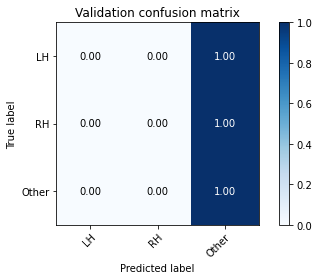

Epoch 1
Train  Loss: 0.80894
Train  Accuracy: 61.9%
Valid  Loss: 1.11047
Valid  Accuracy: 50.0%
model saved
[[ 1  0 12]
 [ 0  0 13]
 [ 0  0 24]]
Normalized confusion matrix


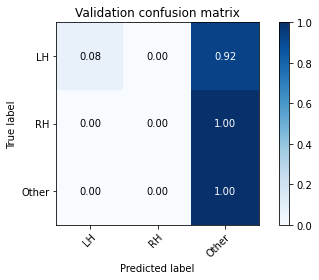

Epoch 2
Train  Loss: 0.73593
Train  Accuracy: 66.0%
Valid  Loss: 1.04007
Valid  Accuracy: 52.0%
model saved
[[ 1  1 11]
 [ 1  1 11]
 [ 0  0 24]]
Normalized confusion matrix


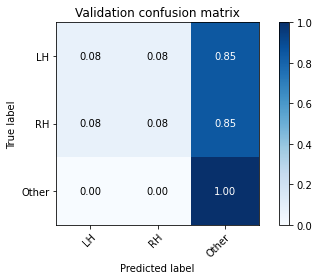

Epoch 3
Train  Loss: 0.68083
Train  Accuracy: 69.0%
Valid  Loss: 0.98517
Valid  Accuracy: 52.0%
model saved
[[ 1  2 10]
 [ 1  1 11]
 [ 0  0 24]]
Normalized confusion matrix


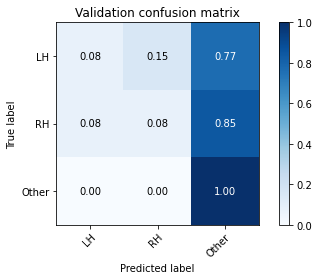

Epoch 4
Train  Loss: 0.63377
Train  Accuracy: 73.9%
Valid  Loss: 0.91622
Valid  Accuracy: 56.0%
model saved
[[ 1  2 10]
 [ 1  3  9]
 [ 0  0 24]]
Normalized confusion matrix


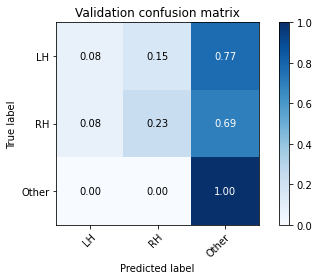

Epoch 5
Train  Loss: 0.58824
Train  Accuracy: 76.7%
Valid  Loss: 0.87804
Valid  Accuracy: 60.0%
model saved
[[ 1  2 10]
 [ 1  5  7]
 [ 0  0 24]]
Normalized confusion matrix


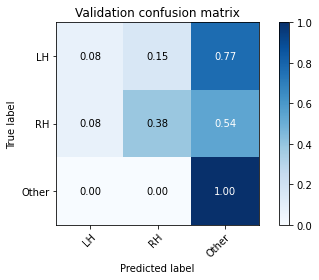

Epoch 6
Train  Loss: 0.54532
Train  Accuracy: 80.0%
Valid  Loss: 0.84138
Valid  Accuracy: 62.0%
model saved
[[ 1  2 10]
 [ 2  6  5]
 [ 0  0 24]]
Normalized confusion matrix


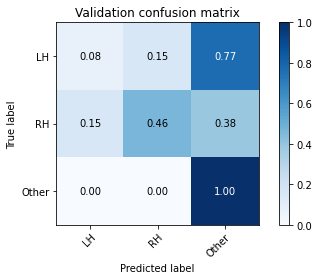

Epoch 7
Train  Loss: 0.50807
Train  Accuracy: 81.1%
Valid  Loss: 0.80330
Valid  Accuracy: 66.0%
model saved
[[ 1  2 10]
 [ 2  8  3]
 [ 0  0 24]]
Normalized confusion matrix


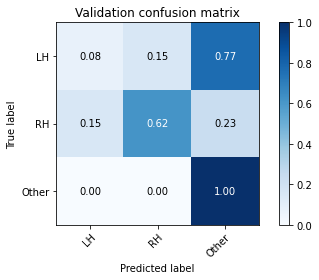

Epoch 8
Train  Loss: 0.48823
Train  Accuracy: 82.6%
Valid  Loss: 0.75356
Valid  Accuracy: 66.0%
model saved
[[ 2  2  9]
 [ 2  8  3]
 [ 1  0 23]]
Normalized confusion matrix


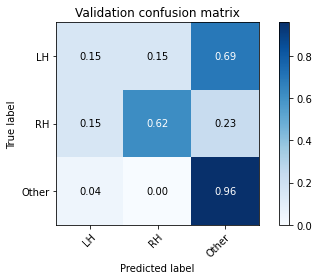

Epoch 9
Train  Loss: 0.45073
Train  Accuracy: 83.8%
Valid  Loss: 0.74712
Valid  Accuracy: 68.0%
model saved
[[ 0  4  9]
 [ 0 11  2]
 [ 1  0 23]]
Normalized confusion matrix


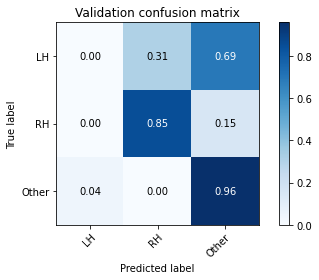

Epoch 10
Train  Loss: 0.41288
Train  Accuracy: 87.1%
Valid  Loss: 0.71013
Valid  Accuracy: 72.0%
model saved
[[ 2  2  9]
 [ 0 11  2]
 [ 1  0 23]]
Normalized confusion matrix


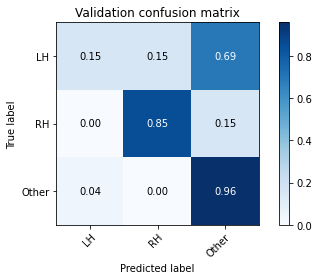

Epoch 11
Train  Loss: 0.38292
Train  Accuracy: 87.9%
Valid  Loss: 0.68111
Valid  Accuracy: 70.0%
Epoch 12
Train  Loss: 0.36075
Train  Accuracy: 90.3%
Valid  Loss: 0.67825
Valid  Accuracy: 70.0%
Epoch 13
Train  Loss: 0.33297
Train  Accuracy: 92.0%
Valid  Loss: 0.63925
Valid  Accuracy: 72.0%
model saved
[[ 3  3  7]
 [ 1 10  2]
 [ 1  0 23]]
Normalized confusion matrix


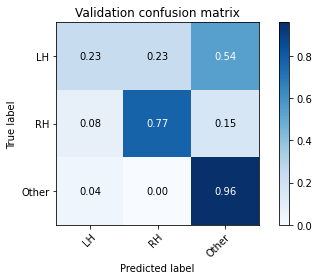

Epoch 14
Train  Loss: 0.30956
Train  Accuracy: 93.3%
Valid  Loss: 0.66595
Valid  Accuracy: 70.0%
time is  15.976327896118164


In [16]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
rng = RandomState(SEED)
from braindecode.util import np_to_var, var_to_np
import torch.nn.functional as F
import time
savebase0='D:\\motor_imagery'
start=time.time()
for i_epoch in range(15):
    
    totol_epoch+=1
    #Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                            batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:,:,:,None]
        batch_y = train_set.y[i_trials]
        #convert from nparray to torch tensor
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(totol_epoch))
    average_acc=[]
    average_loss=[]
    
    #here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                            batch_size=60)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:,:,:,None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp=toutputs.cpu()
                outputs=temp.detach().numpy()
            else:
                temp=toutputs.cpu()
                outputs=np.concatenate((outputs,temp.detach().numpy()))
        net_target=np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        
        print("{:6s} Accuracy: {:.1f}%".format(
            setname, accuracy * 100))
#         print(predicted_labels)
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            if accuracy>=highest_acc:
                savename=savebase0+'\\cnn_model_MI.pth'
                
                torch.save({
                    'in_chans': in_chans,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'n_classes': 3,
                    'input_time_length':input_time_length
                }, savename)

                highest_acc=accuracy
                print('model saved')
                plot_confusion_matrix(dataset.y, predicted_labels, classes=['LH','RH','Other'], normalize=True,
                      title='Validation confusion matrix')
                plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end=time.time()

print('time is ', end-start)
#3.19 50.7 epoch3 0.65 70.3

**Here we can observe that on trainig set, the classification accuracy is fairly high, while it is not able to generalised well to the new subject directly with this simple strategy, this subject is just a extreme case for tutorial purpose. Usually validation and test accuracy of a new subject decrease a lot (sometimes 30% or more). Transfer learning strategies should be used to solve this problem.**

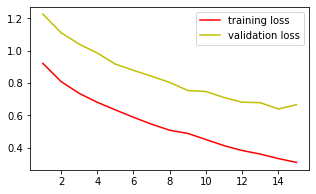

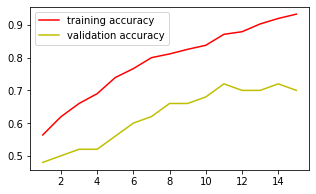

In [17]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (5.0, 3.0)
t = np.arange(0.0, len(Tlosses), 1)+1
plt.plot(t,Tlosses,'r',t,Vlosses,'y')
plt.legend(('training loss', 'validation loss'))
plt.show()
plt.plot(t,Taccuracies,'r',t,Vaccuracies,'y')
plt.legend(('training accuracy', 'validation accuracy'))
plt.show()

feature shape is:  (1, 40, 44, 1)
feature reduction shape is:  (1, 50, 1, 1)
testset Loss: 0.62913
testset Accuracy: 73.0%
[[ 50  19  37]
 [ 17  67  22]
 [ 12   8 194]]
Normalized confusion matrix


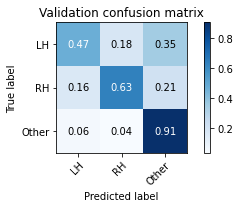

In [19]:
from braindecode.util import np_to_var, var_to_np
import torch.nn.functional as F
labelsize=3
model = util.shallow_net.EEGShallowClassifier(in_chans, labelsize, input_time_length, return_feature=False)
if cuda:
    model.cuda()
checkpoint = torch.load(savebase0+'\\cnn_model_MI.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc=[]
average_loss=[]
setname='testset'
dataset=test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                    batch_size=30)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
#             print(i_trials)
    batch_X = dataset.X[i_trials][:,:,:,None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp=toutputs.cpu()
        outputs=temp.detach().numpy()
    else:
        temp=toutputs.cpu()
        outputs=np.concatenate((outputs,temp.detach().numpy()))
net_target=np_to_var(dataset.y)
#         print(outputs)
#         if cuda:
#             net_target = net_target.cuda()
#         print(outputs)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(
    setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(
    setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, classes=['LH','RH','Other'], normalize=True,
                  title='Validation confusion matrix')
plt.show()